# Plottng Embedded Space

Load modules.

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

In [2]:
import corner
from matplotlib.patches import Patch

In [3]:
import sys
print(sys.executable)

import torch
print(torch.__version__)
print(torch.version.cuda)
print(torch.cuda.is_available())

/work/submit/kyoon/miniforge3/envs/ssm/bin/python
2.4.1+cu121
12.1
True


In [4]:
from data import DataGenerator

Using device=device(type='cuda')


In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using {device=}')

Using device=device(type='cuda')


Open ```.pt``` files that are produced by ```data.py```.

In [6]:
datadir    = '/ceph/submit/data/user/k/kyoon/KYoonStudy/ssm_regression/SHO'
train_dict = torch.load(os.path.join(datadir, 'train.pt'), map_location=torch.device(device))
val_dict   = torch.load(os.path.join(datadir, 'val.pt'), map_location=torch.device(device))
test_dict  = torch.load(os.path.join(datadir, 'test.pt'), map_location=torch.device(device))

/tmp/ipykernel_1456143/3299694828.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_dict = torch.load(os.path.join(datadir, 'train.pt'), map_location=torch.device(de

In [8]:
train_data = DataGenerator(train_dict)
val_data   = DataGenerator(val_dict)
test_data  = DataGenerator(test_dict)

In [9]:
data_unshifted_vals = test_dict['data_unshifted'][:,0]
data_shifted_vals = test_dict['data_shifted'][:,0]

In [15]:
test_data_loader = DataLoader(
    test_data, batch_size=1, num_workers=0,
    shuffle=False
)

Load the embedding file.

In [11]:
from models import SimilarityEmbedding

In [16]:
# Path to the saved model
model_path = '/ceph/submit/data/user/k/kyoon/KYoonStudy/ssm_regression/SHO/models/model.CNN.20250503-220716.path'

In [17]:
similarity_embedding = SimilarityEmbedding(num_hidden_layers_h=2).to(device)
state_dict = torch.load(model_path, map_location=device)
similarity_embedding.load_state_dict(state_dict)
similarity_embedding.eval()

/tmp/ipykernel_1456143/1199819144.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location=device)


SimilarityEmbedding(
  (layers_f): ConvResidualNet(
    (initial_layer): Conv1d(10, 20, kernel_size=(21,), stride=(1,), padding=same)
    (blocks): ModuleList(
      (0-3): 4 x ConvResidualBlock(
        (batch_norm_layers): ModuleList(
          (0-1): 2 x BatchNorm1d(20, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        )
        (conv_layers): ModuleList(
          (0-1): 2 x Conv1d(20, 20, kernel_size=(21,), stride=(1,), padding=same)
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (final_layer): Conv1d(20, 1, kernel_size=(1,), stride=(1,), padding=same)
  )
  (contraction_layer): Sequential(
    (0): Linear(in_features=200, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=3, bias=True)
  )
  (expander_layer): Linear(in_features=3, out_features=20, bias=True)
  (layers_h): ModuleList(
    (0-1): 2 x Linear(in_features=20, out_features=20, bias=True)
  )
  (final_layer): Linear(in_features=2

## Varying omega

The theta_test tensors are of size \[num_simulations, num_repeats=10, 3\], where the 3 variables are omega, beta, shift.
The data_test tensors are of size \[num_simulations, num_repeats=10, 200\], where the 200 data points are the displacement values of the SHO that correspond to 200 data points in unshifted time.

In [18]:

similarity_outputs_1 = []

for idx, (_, theta_test, data_test, data_test_orig) in enumerate(test_data_loader):
    if not ((theta_test.T[0][0][0] < 0.4) and (theta_test.T[0][0][0] > 0.2)):
        continue
    with torch.no_grad():
        _, similarity_output = similarity_embedding(data_test)
    similarity_outputs_1.append(similarity_output)
    
similarity_outputs_2 = []

for idx, (_, theta_test, data_test, data_test_orig) in enumerate(test_data_loader):
    if not ((theta_test.T[0][0][0] < 1.6) and (theta_test.T[0][0][0] > 1.4)):
        continue
    with torch.no_grad():
        _, similarity_output = similarity_embedding(data_test)
    similarity_outputs_2.append(similarity_output)

similarity_outputs_3 = []

for idx, (_, theta_test, data_test, data_test_orig) in enumerate(test_data_loader):
    if not ((theta_test.T[0][0][0] < 0.8) and (theta_test.T[0][0][0] > 0.6)):
        continue
    with torch.no_grad():
        _, similarity_output = similarity_embedding(data_test)
    similarity_outputs_3.append(similarity_output)

similarity_outputs_4 = []

for idx, (_, theta_test, data_test, data_test_orig) in enumerate(test_data_loader):
    if not ((theta_test.T[0][0][0] < 0.6) and (theta_test.T[0][0][0] > 0.4)):
        continue
    with torch.no_grad():
        _, similarity_output = similarity_embedding(data_test)
    similarity_outputs_4.append(similarity_output)

/tmp/ipykernel_1456143/3327947938.py:4: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3697.)
  if not ((theta_test.T[0][0][0] < 0.4) and (theta_test.T[0][0][0] > 0.2)):


In [19]:
similarity_outputs_1 = torch.stack(similarity_outputs_1)
similarity_outputs_2 = torch.stack(similarity_outputs_2)
similarity_outputs_3 = torch.stack(similarity_outputs_3)
similarity_outputs_4 = torch.stack(similarity_outputs_4)

In [20]:
print(similarity_outputs_1.shape)
print(similarity_outputs_2.shape)
print(similarity_outputs_3.shape)
print(similarity_outputs_4.shape)

torch.Size([1076, 1, 1, 3])
torch.Size([984, 1, 1, 3])
torch.Size([1023, 1, 1, 3])
torch.Size([1058, 1, 1, 3])


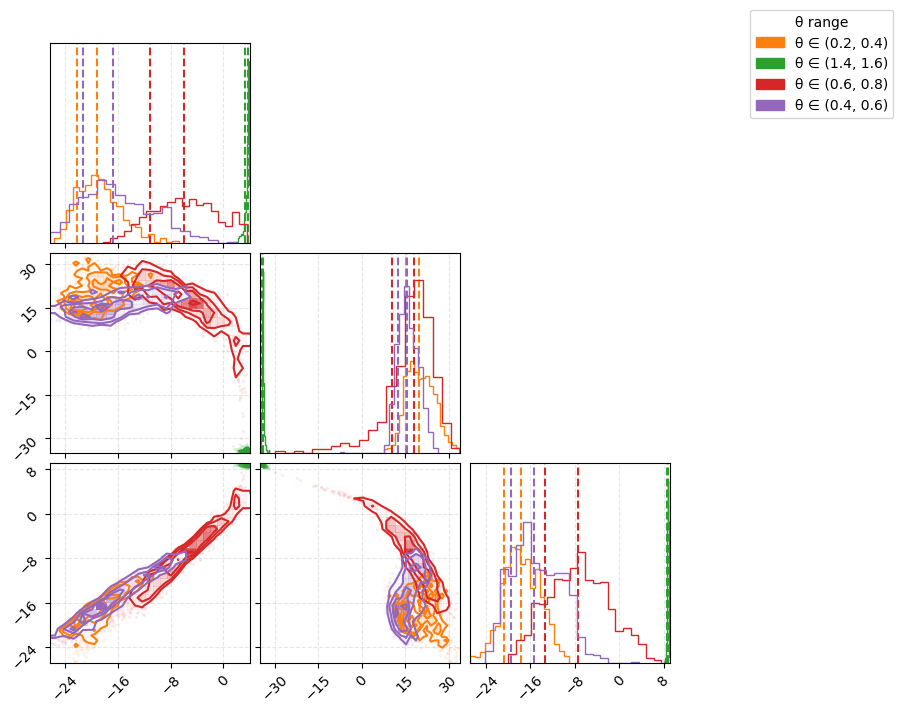

In [21]:
num_dim = 3

figure = corner.corner(
    similarity_outputs_1.cpu().numpy().reshape((similarity_outputs_1.shape[0]*similarity_outputs_1.shape[2], num_dim)),
    quantiles=[0.16, 0.5], color="C1"
)

figure = corner.corner(
    similarity_outputs_2.cpu().numpy().reshape((similarity_outputs_2.shape[0]*similarity_outputs_2.shape[2], num_dim)),
    quantiles=[0.16, 0.5], fig=figure, color="C2"
)

figure = corner.corner(
    similarity_outputs_3.cpu().numpy().reshape((similarity_outputs_3.shape[0]*similarity_outputs_3.shape[2], num_dim)),
    quantiles=[0.16, 0.5], fig=figure, color="C3"
)

figure = corner.corner(
    similarity_outputs_4.cpu().numpy().reshape((similarity_outputs_4.shape[0]*similarity_outputs_4.shape[2], num_dim)),
    quantiles=[0.16, 0.5], fig=figure, color="C4"
)

# Add legend
legend_labels = [
    Patch(color="C1", label="θ ∈ (0.2, 0.4)"),
    Patch(color="C2", label="θ ∈ (1.4, 1.6)"),
    Patch(color="C3", label="θ ∈ (0.6, 0.8)"),
    Patch(color="C4", label="θ ∈ (0.4, 0.6)")
]

# Position legend outside top-left corner
figure.legend(handles=legend_labels, loc='upper right', bbox_to_anchor=(1.25, 1.0), title='θ range')

# Add gridlines
for ax in figure.get_axes():
    ax.grid(True, linestyle='--', alpha=0.3)

## Varying beta

In [22]:
similarity_embedding.train(False)

similarity_outputs_5 = []

for idx, (_, theta_test, data_test, data_test_orig) in enumerate(test_data_loader):
    if not ((theta_test.T[0][1][0] < 0.2) and (theta_test.T[0][1][0] > 0.1)):
        continue
    with torch.no_grad():
        _, similarity_output = similarity_embedding(data_test)
    similarity_outputs_5.append(similarity_output)

similarity_outputs_6 = []

for idx, (_, theta_test, data_test, data_test_orig) in enumerate(test_data_loader):
    if not ((theta_test.T[0][1][0] < 0.3) and (theta_test.T[0][1][0] > 0.2)):
        continue
    with torch.no_grad():
        _, similarity_output = similarity_embedding(data_test)
    similarity_outputs_6.append(similarity_output)
    
similarity_outputs_7 = []

for idx, (_, theta_test, data_test, data_test_orig) in enumerate(test_data_loader):
    if not ((theta_test.T[0][1][0] < 0.4) and (theta_test.T[0][1][0] > 0.3)):
        continue
    with torch.no_grad():
        _, similarity_output = similarity_embedding(data_test)
    similarity_outputs_7.append(similarity_output)
    
similarity_outputs_8 = []

for idx, (_, theta_test, data_test, data_test_orig) in enumerate(test_data_loader):
    if not ((theta_test.T[0][1][0] < 0.5) and (theta_test.T[0][1][0] > 0.4)):
        continue
    with torch.no_grad():
        _, similarity_output = similarity_embedding(data_test)
    similarity_outputs_8.append(similarity_output) 

In [23]:
similarity_outputs_5 = torch.stack(similarity_outputs_5)
similarity_outputs_6 = torch.stack(similarity_outputs_6)
similarity_outputs_7 = torch.stack(similarity_outputs_7)
similarity_outputs_8 = torch.stack(similarity_outputs_8)

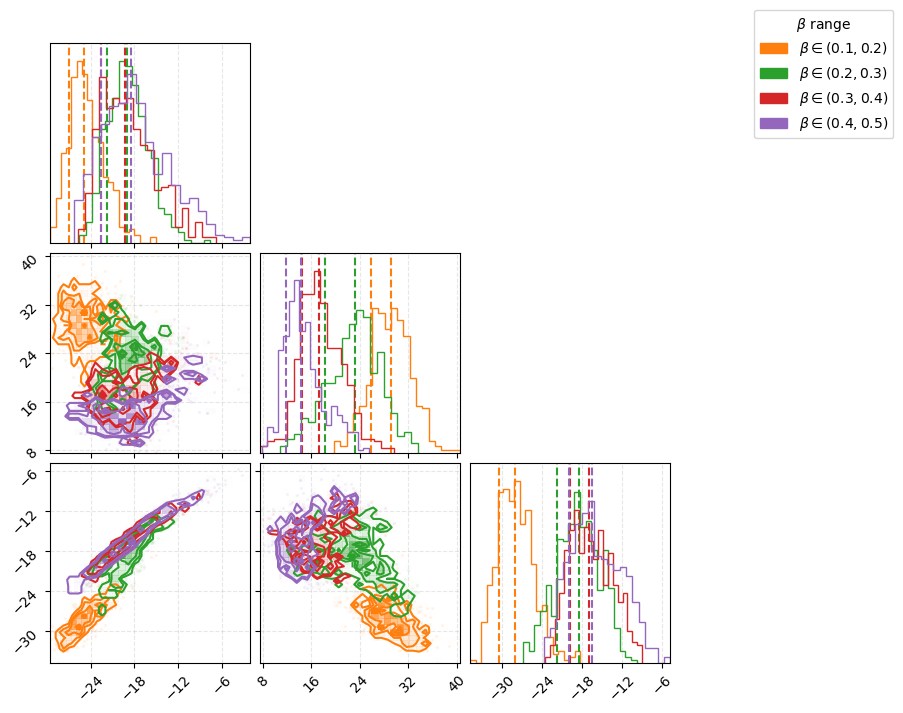

In [24]:
figure = corner.corner(
    similarity_outputs_5.cpu().numpy().reshape((similarity_outputs_5.shape[0]*similarity_outputs_5.shape[2], num_dim)),
    quantiles=[0.16, 0.5], color="C1"
)

figure = corner.corner(
    similarity_outputs_6.cpu().numpy().reshape((similarity_outputs_6.shape[0]*similarity_outputs_6.shape[2], num_dim)),
    quantiles=[0.16, 0.5], fig=figure, color="C2"
)

figure = corner.corner(
    similarity_outputs_7.cpu().numpy().reshape((similarity_outputs_7.shape[0]*similarity_outputs_7.shape[2], num_dim)),
    quantiles=[0.16, 0.5], fig=figure, color="C3"
)

figure = corner.corner(
    similarity_outputs_8.cpu().numpy().reshape((similarity_outputs_8.shape[0]*similarity_outputs_8.shape[2], num_dim)),
    quantiles=[0.16, 0.5], fig=figure, color="C4"
)


# Add legend
legend_labels = [
    Patch(color="C1", label=r'$\beta \in (0.1, 0.2)$'),
    Patch(color="C2", label=r'$\beta \in (0.2, 0.3)$'),
    Patch(color="C3", label=r'$\beta \in (0.3, 0.4)$'),
    Patch(color="C4", label=r'$\beta \in (0.4, 0.5)$')
]

# Position legend outside top-left corner
figure.legend(handles=legend_labels, loc='upper right', bbox_to_anchor=(1.25, 1.0), title=r'$\beta$ range')

# Add gridlines
for ax in figure.get_axes():
    ax.grid(True, linestyle='--', alpha=0.3)

## Varying omega with constant beta

In [25]:
similarity_outputs_9 = []

for idx, (_, theta_test, data_test, data_test_orig) in enumerate(test_data_loader):
    if not ((theta_test[0][0][0] < 0.75) and (theta_test[0][0][0] > 0.5) and \
            (theta_test[0][0][1] < 0.3) and (theta_test[0][0][1] > 0.2)):
        continue
    with torch.no_grad():
        _, similarity_output = similarity_embedding(data_test)
    similarity_outputs_9.append(similarity_output)

similarity_outputs_10 = []

for idx, (_, theta_test, data_test, data_test_orig) in enumerate(test_data_loader):
    if not ((theta_test[0][0][0] < 1.5) and (theta_test[0][0][0] > 1.25) and \
            (theta_test[0][0][1] < 0.2) and (theta_test[0][0][1] > 0.1)):
        continue
    with torch.no_grad():
        _, similarity_output = similarity_embedding(data_test)
#         print(similarity_output.shape)
    similarity_outputs_10.append(similarity_output)
    
similarity_outputs_11 = []

for idx, (_, theta_test, data_test, data_test_orig) in enumerate(test_data_loader):
    if not ((theta_test[0][0][0] < 1.75) and (theta_test[0][0][0] > 1.5) and \
            (theta_test[0][0][1] < 0.4) and (theta_test[0][0][1] > 0.3)):
        continue
    with torch.no_grad():
        _, similarity_output = similarity_embedding(data_test)
    similarity_outputs_11.append(similarity_output)

similarity_outputs_12 = []

for idx, (_, theta_test, data_test, data_test_orig) in enumerate(test_data_loader):
    if not ((theta_test[0][0][0] < 0.5) and (theta_test[0][0][0] > 0.25) and \
            (theta_test[0][0][1] < 0.5) and (theta_test[0][0][1] > 0.4)):
        continue
    with torch.no_grad():
        _, similarity_output = similarity_embedding(data_test)
    similarity_outputs_12.append(similarity_output)

In [26]:
similarity_outputs_9 = torch.stack(similarity_outputs_9)
similarity_outputs_10 = torch.stack(similarity_outputs_10)
similarity_outputs_11 = torch.stack(similarity_outputs_11)
similarity_outputs_12 = torch.stack(similarity_outputs_12)

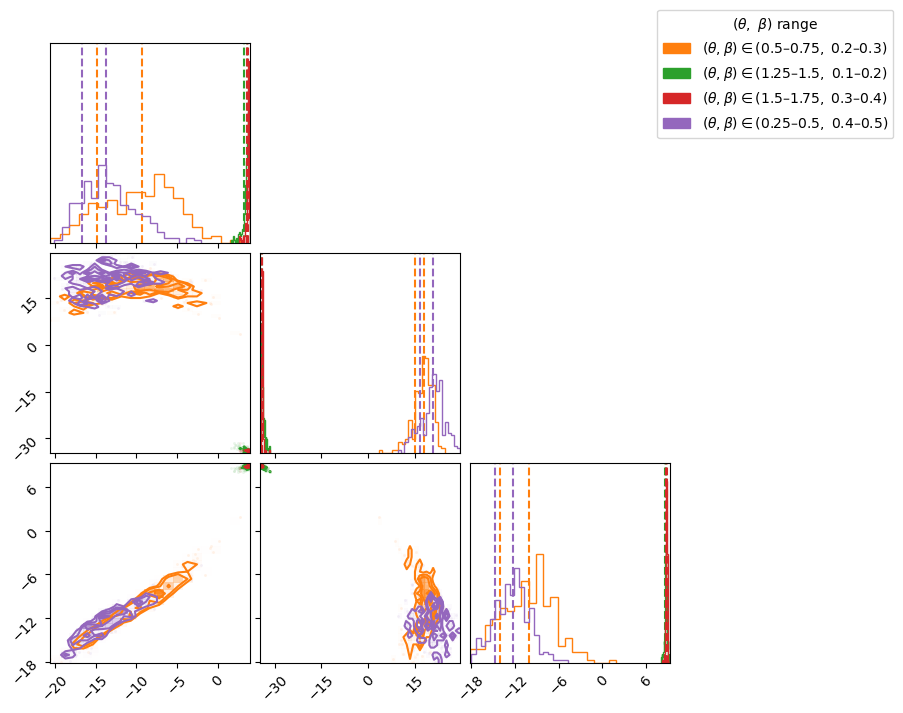

In [27]:
figure = corner.corner(
    similarity_outputs_9.cpu().numpy().reshape((similarity_outputs_9.shape[0]*similarity_outputs_9.shape[2], num_dim)),
    quantiles=[0.16, 0.5], color="C1"
)

figure = corner.corner(
    similarity_outputs_10.cpu().numpy().reshape((similarity_outputs_10.shape[0]*similarity_outputs_10.shape[2], num_dim)),
    quantiles=[0.16, 0.5], fig=figure, color="C2"
)

figure = corner.corner(
    similarity_outputs_11.cpu().numpy().reshape((similarity_outputs_11.shape[0]*similarity_outputs_11.shape[2], num_dim)),
    quantiles=[0.16, 0.5], fig=figure, color="C3"
)

figure = corner.corner(
    similarity_outputs_12.cpu().numpy().reshape((similarity_outputs_12.shape[0]*similarity_outputs_12.shape[2], num_dim)),
    quantiles=[0.16, 0.5], fig=figure, color="C4"
)

# Add a detailed legend for combined (θ, β) filtering
legend_labels = [
    Patch(color="C1", label=r'$(\theta, \beta) \in (0.5\text{–}0.75,\ 0.2\text{–}0.3)$'),
    Patch(color="C2", label=r'$(\theta, \beta) \in (1.25\text{–}1.5,\ 0.1\text{–}0.2)$'),
    Patch(color="C3", label=r'$(\theta, \beta) \in (1.5\text{–}1.75,\ 0.3\text{–}0.4)$'),
    Patch(color="C4", label=r'$(\theta, \beta) \in (0.25\text{–}0.5,\ 0.4\text{–}0.5)$'),
]

figure.legend(handles=legend_labels, loc='upper right', bbox_to_anchor=(1.25, 1.0), title=r'$(\theta,\ \beta)$ range')

# Parameter Estimation

In [28]:
from nflows.flows import Flow
from nflows.transforms import CompositeTransform, RandomPermutation
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform
from nflows.distributions import StandardNormal

In [29]:
# Path to the saved flow
flow_path = '/ceph/submit/data/user/k/kyoon/KYoonStudy/ssm_regression/SHO/models/flow.CNN.20250504-002758.path'

In [30]:
num_transforms = 5
num_blocks = 4
hidden_features = 30
context_features = 3 # needs to fit the pretraining embedding dimensionality
num_points = 200 # length of time series
num_repeats = 10 # number of augmentations

class EmbeddingNet(nn.Module):
    """Wrapper around the similarity embedding defined above"""
    def __init__(self, pretraining, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.representation_net = SimilarityEmbedding(num_hidden_layers_h=2)
        self.representation_net.load_state_dict(torch.load(pretraining, map_location=device))

        # the expander network is unused and hence don't track gradients
        for name, param in self.representation_net.named_parameters():
            if 'expander_layer' in name or 'layers_h' in name or 'final_layer' in name:
                param.requires_grad = False

        # freeze part of the conv layer of embedding_net
        for name, param in self.representation_net.named_parameters():
            if 'layers_f.blocks.0' in name or 'layers_f.blocks.1' in name:
                param.requires_grad = False

        self.context_layer = nn.Identity()

    def forward(self, x):
        batch_size, _, dims = x.shape
        x = x.reshape(batch_size, 1, dims).repeat(1, num_repeats, 1)
        _, rep = self.representation_net(x)
        return self.context_layer(rep.reshape(batch_size, context_features))

base_dist = StandardNormal([2])
transforms = []
for _ in range(num_transforms):
    block = [
        MaskedAffineAutoregressiveTransform(
            features=2,  # 2-dim posterior
            hidden_features=hidden_features,
            context_features=context_features,
            num_blocks=num_blocks,
            activation=torch.tanh,
            use_batch_norm=False,
            use_residual_blocks=True,
            dropout_probability=0.01,
        ),
        RandomPermutation(features=2)
    ]
    transforms += block

transform = CompositeTransform(transforms)

embedding_net = EmbeddingNet(model_path)

flow = Flow(transform, base_dist, embedding_net).to(device=device)

/tmp/ipykernel_1456143/745723915.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.representation_net.load_state_dict(torch.load(pretraining, map_location=device))


In [31]:
flow.load_state_dict(torch.load(flow_path, map_location=device))
flow.eval()

/tmp/ipykernel_1456143/825699016.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  flow.load_state_dict(torch.load(flow_path, map_location=device))


Flow(
  (_transform): CompositeTransform(
    (_transforms): ModuleList(
      (0): MaskedAffineAutoregressiveTransform(
        (autoregressive_net): MADE(
          (initial_layer): MaskedLinear(in_features=2, out_features=30, bias=True)
          (context_layer): Linear(in_features=3, out_features=30, bias=True)
          (blocks): ModuleList(
            (0-3): 4 x MaskedResidualBlock(
              (context_layer): Linear(in_features=3, out_features=30, bias=True)
              (linear_layers): ModuleList(
                (0-1): 2 x MaskedLinear(in_features=30, out_features=30, bias=True)
              )
              (dropout): Dropout(p=0.01, inplace=False)
            )
          )
          (final_layer): MaskedLinear(in_features=30, out_features=4, bias=True)
        )
      )
      (1): RandomPermutation()
      (2): MaskedAffineAutoregressiveTransform(
        (autoregressive_net): MADE(
          (initial_layer): MaskedLinear(in_features=2, out_features=30, bias=True)
    

In [32]:
from IPython.display import clear_output
from time import sleep

In [33]:
def live_plot_samples(samples, truth):
    clear_output(wait=True)
    sleep(0.5)
    figure = corner.corner(
        samples.numpy(), quantiles=[0.05, 0.5, 0.95],
        show_titles=True,
        labels=["omega_0", "beta",],
        truth=truth,
    )
    print(truth)

    corner.overplot_lines(figure, truth, color="C1")
    corner.overplot_points(figure, truth[None], marker="s", color="C1")

tensor([0.7544, 0.2462])


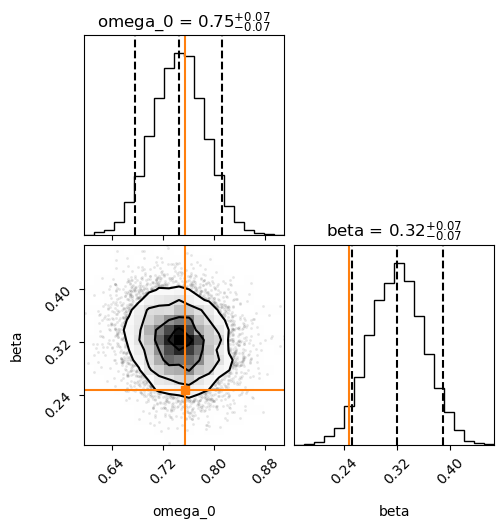

In [34]:
for idx, (_, theta_test, data_test, data_orig) in enumerate(test_data_loader):
    if idx % 1000 !=0: continue 
    with torch.no_grad():
        samples = flow.sample(10000, context=data_test[0][0].reshape((1, 1, 200)))
    live_plot_samples(samples.cpu().reshape(10000, 2), theta_test[0][0].cpu()[..., 0:2])
    plt.show()

# Compute $\mathrm{(truth) - (prediction)}$

In [35]:
# Define a function to compute z-scores
def compute_z_scores(predictions, truths):
    mean = predictions.mean()
    std = predictions.std()
    z_scores = (predictions - truths) / std
    return z_scores

In [61]:
def compute_diff(predictions, truths):
    return predictions - truths

In [36]:
def flow_compute_vals(flow, test_data_loader, batch_size=16, num_samples=1000, compute_on_cpu=False):
    pred_omega, truth_omega = [], []
    pred_beta, truth_beta = [], []

    batch_contexts, batch_truths = [], []
    for idx, (_, theta_test, data_test, _) in enumerate(test_data_loader):
        batch_contexts.append(data_test[0][0].reshape(1, 1, 200))  # shape: (1, 1, 200)
        batch_truths.append(theta_test[0][0, :2])

        # Process in batches
        if (idx + 1) % batch_size == 0 or (idx + 1) == len(test_data_loader):
            contexts = torch.cat(batch_contexts, dim=0).to(device)   # (B, 1, 200)
            truths = torch.stack(batch_truths).cpu()                 # (B, 2)

            with torch.no_grad():
                samples = flow.sample(num_samples, context=contexts)   # (B, num_samples, param_dim)

            samples = samples[..., :2] # (B, num_samples, 2)

            # Move samples to CPU if required
            if compute_on_cpu:
                samples = samples.cpu()
                truths = truths.cpu()
            
            preds = samples.mean(dim=1)                            # (B, 2)
            
            pred_omega.extend(preds[:, 0].tolist())
            pred_beta.extend(preds[:, 1].tolist())
            truth_omega.extend(truths[:, 0].tolist())
            truth_beta.extend(truths[:, 1].tolist())

            # Clear for next batch
            batch_contexts = []
            batch_truths = []

    pred_omega, truth_omega = torch.tensor(pred_omega), torch.tensor(truth_omega)
    pred_beta, truth_beta = torch.tensor(pred_beta), torch.tensor(truth_beta)

    return pred_omega, truth_omega, pred_beta, truth_beta


In [37]:
flow_pred_omega, flow_truth_omega, flow_pred_beta, flow_truth_beta = flow_compute_vals(flow, test_data_loader, batch_size=16, num_samples=1000, compute_on_cpu=False)

In [62]:
# Compute z-scores for omega and beta
flow_z_score_omega = compute_z_scores(flow_pred_omega, flow_truth_omega)
flow_z_score_beta = compute_z_scores(flow_pred_beta, flow_truth_beta)
flow_diff_omega = compute_diff(flow_pred_omega, flow_truth_omega)
flow_diff_beta = compute_diff(flow_pred_beta, flow_truth_beta)

# Stack into (N, 2) array
flow_z_scores = np.stack([flow_z_score_omega.numpy(), flow_z_score_beta.numpy()], axis=1)
flow_diffs = np.stack([flow_diff_omega.numpy(), flow_diff_beta.numpy()], axis=1)

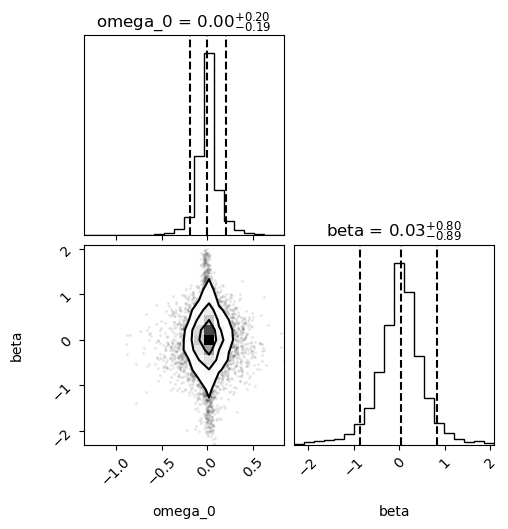

In [39]:
figure = corner.corner(
        flow_z_scores, quantiles=[0.05, 0.5, 0.95],
        show_titles=True,
        labels=["omega_0", "beta",]
    )

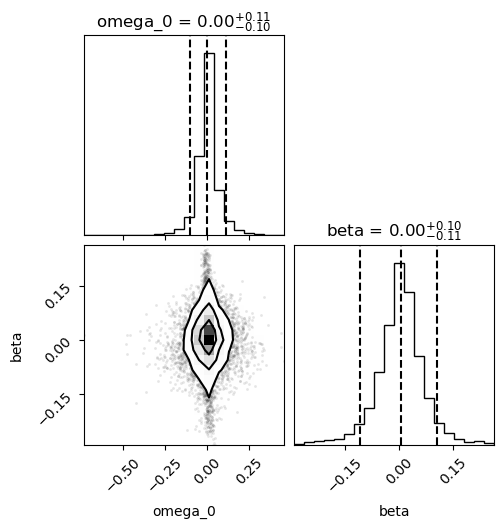

In [63]:
figure = corner.corner(
        flow_diffs, quantiles=[0.05, 0.5, 0.95],
        show_titles=True,
        labels=["omega_0", "beta",]
    )

# SSM Regression

In [40]:
from s4d import S4D
dropout_fn = nn.Dropout2d

In [41]:
# definition of SSM
class S4Model(nn.Module):

    def __init__(
        self,
        d_input,
        d_output=10,
        d_model=256,
        n_layers=4,
        dropout=0.2,
        prenorm=False,
    ):
        super().__init__()
        self.prenorm = prenorm
        self.encoder = nn.Linear(d_input, d_model)
        # Stack S4 layers as residual blocks
        self.s4_layers = nn.ModuleList()
        self.norms = nn.ModuleList()
        self.dropouts = nn.ModuleList()
        for _ in range(n_layers):
            self.s4_layers.append(
                S4D(d_model, dropout=dropout, transposed=True, lr=min(0.001, 0.01))
            )
            self.norms.append(nn.LayerNorm(d_model))
            self.dropouts.append(dropout_fn(dropout))
        # Linear decoder
        self.decoder = nn.Linear(d_model, d_output)

    def forward(self, x):
        """
        Input x is shape (B, L, d_input)
        """
        x = self.encoder(x)  # (B, L, d_input) -> (B, L, d_model)
        x = x.transpose(-1, -2)  # (B, L, d_model) -> (B, d_model, L)
        for layer, norm, dropout in zip(self.s4_layers, self.norms, self.dropouts):
            # Each iteration of this loop will map (B, d_model, L) -> (B, d_model, L)
            z = x
            if self.prenorm:
                # Prenorm
                z = norm(z.transpose(-1, -2)).transpose(-1, -2)
            # Apply S4 block: we ignore the state input and output
            z, _ = layer(z)
            # Dropout on the output of the S4 block
            z = dropout(z)
            # Residual connection
            x = z + x
            if not self.prenorm:
                # Postnorm
                x = norm(x.transpose(-1, -2)).transpose(-1, -2)
        x = x.transpose(-1, -2)
        # Pooling: average pooling over the sequence length
        x = x.mean(dim=1)
        # Decode the outputs
        x = self.decoder(x)  # (B, d_model) -> (B, d_output)
        return x

In [42]:
d_input = 1 # number of channels (here only one time series -> 1)
d_output = 2 # number of outputs (here regression, so one output, can be several, if we want to regress several quantities)

ssm_model = S4Model(d_input=d_input, d_output=d_output, d_model=6, n_layers=4, dropout=0.0, prenorm=False)
ssm_model = ssm_model.to(device)

In [43]:
# Path to the saved regression model
ssm_model_path = '/ceph/submit/data/user/k/kyoon/KYoonStudy/ssm_regression/SHO/models/model.SSM.20250504-001204.path'

In [44]:
ssm_model.load_state_dict(torch.load(ssm_model_path, map_location=device))
ssm_model.eval()

/tmp/ipykernel_1456143/1859937258.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ssm_model.load_state_dict(torch.load(ssm_model_path, map_location=device))


S4Model(
  (encoder): Linear(in_features=1, out_features=6, bias=True)
  (s4_layers): ModuleList(
    (0-3): 4 x S4D(
      (kernel): S4DKernel()
      (activation): GELU(approximate='none')
      (dropout): Identity()
      (output_linear): Sequential(
        (0): Conv1d(6, 12, kernel_size=(1,), stride=(1,))
        (1): GLU(dim=-2)
      )
    )
  )
  (norms): ModuleList(
    (0-3): 4 x LayerNorm((6,), eps=1e-05, elementwise_affine=True)
  )
  (dropouts): ModuleList(
    (0-3): 4 x Dropout2d(p=0.0, inplace=False)
  )
  (decoder): Linear(in_features=6, out_features=2, bias=True)
)

Load test data and get regression output.

In [45]:
def reshaping(batch):
    theta_u, theta_s, data_u, data_s = batch

    # remove repeat (take only first repeat for unshifted data)
    inputs = data_u[:, 0, :].unsqueeze(-1) if data_u.ndim == 3 else data_u.unsqueeze(-1)  # [B, 200, 1]
    targets = theta_u[:, 0, :2] if theta_u.ndim == 3 else theta_u[:, :2]  # [B, 2]

    return inputs, targets

In [53]:
test_data_loader = DataLoader(
    test_data, batch_size=256, num_workers=0,
    shuffle=False
)

In [47]:
next(ssm_model.parameters()).device

device(type='cuda', index=0)

In [56]:
def ssm_compute_vals(ssm, test_data_loader, batch_size=16, compute_on_cpu=False):
    pred_omega, truth_omega = [], []
    pred_beta, truth_beta = [], []

    batch_contexts, batch_truths = [], []

    device = next(ssm.parameters()).device
    ssm.eval()

    for idx, vals in enumerate(test_data_loader):
        inputs, truths = reshaping(vals)
        batch_contexts.append(inputs)  # shape: (1, 1, 200)
        batch_truths.append(truths)  # shape: (1, 2)

        # Process in batches
        if (idx + 1) % batch_size == 0 or (idx + 1) == len(test_data_loader):
            contexts = torch.cat(batch_contexts, dim=0).to(device)   # (B, 1, 200)
            truths = torch.cat(batch_truths).to(device)                 # (B, 2)

            with torch.no_grad():
                preds = ssm(contexts)

            if preds.ndim == 3:
                preds = preds.squeeze(1)  # e.g., (B, 1, 2) → (B, 2)

            # Move samples to CPU if required
            if compute_on_cpu:
                preds = preds.cpu()
                truths = truths.cpu()                       # (B, 2)
            
            pred_omega.extend(preds[:, 0].tolist())
            pred_beta.extend(preds[:, 1].tolist())
            truth_omega.extend(truths[:, 0].tolist())
            truth_beta.extend(truths[:, 1].tolist())

            # Clear for next batch
            batch_contexts.clear()
            batch_truths.clear()

    return (
        torch.tensor(pred_omega),
        torch.tensor(truth_omega),
        torch.tensor(pred_beta),
        torch.tensor(truth_beta),
    )


In [57]:
ssm_pred_omega, ssm_truth_omega, ssm_pred_beta, ssm_truth_beta = ssm_compute_vals(ssm_model, test_data_loader, compute_on_cpu=False)

/work/submit/kyoon/miniforge3/envs/ssm/lib/python3.10/site-packages/torch/nn/functional.py:1381: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn("dropout2d: Received a 3D input to dropout2d and assuming that channel-wise "


In [64]:
# Compute z-scores for omega and beta
ssm_z_score_omega = compute_z_scores(ssm_pred_omega, ssm_truth_omega)
ssm_z_score_beta = compute_z_scores(ssm_pred_beta, ssm_truth_beta)
ssm_diff_omega = compute_diff(ssm_pred_omega, ssm_truth_omega)
ssm_diff_beta = compute_diff(ssm_pred_beta, ssm_truth_beta)

# Stack into (N, 2) array
ssm_z_scores = np.stack([ssm_z_score_omega.numpy(), ssm_z_score_beta.numpy()], axis=1)
ssm_diffs = np.stack([ssm_diff_omega.numpy(), ssm_diff_beta.numpy()], axis=1)

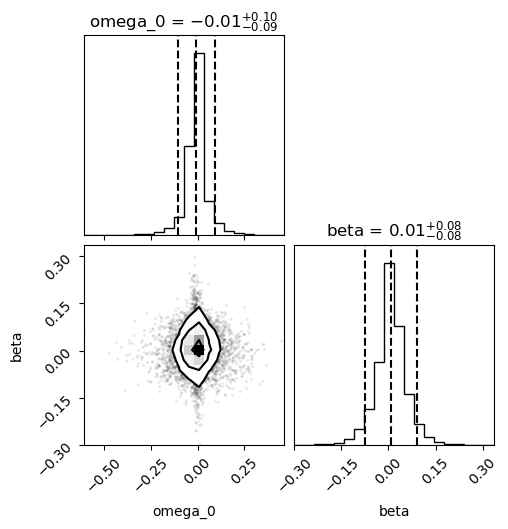

In [65]:
figure = corner.corner(
        ssm_diffs, quantiles=[0.05, 0.5, 0.95],
        show_titles=True,
        labels=["omega_0", "beta",]
    )